# 65% accuracy on test !

In [37]:
## Train model
# resnet18
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights

# Variables
train_folder = 'train'
val_folder = 'test'
num_classes = 7
image_size = 224
batch_size = 16
epochs = 5

# Data augmentation
data_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the data
train_dataset = ImageFolder(train_folder, transform=data_transforms)
val_dataset = ImageFolder(val_folder, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Load pre-trained MobileNetV2
resnet18_base = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Freeze the last layer
num_ftrs = resnet18_base.fc.in_features
resnet18_base.fc = nn.Identity()

# Custom top layers
output_layer = nn.Sequential(
    nn.Linear(num_ftrs, num_classes),
)
resnet18_base.add_module('output', output_layer)

# Define the criterion, optimizer, and device
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_base.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
resnet18_base.train()
resnet18_base.to(device)


# Initialize best validation loss and model saving path
best_val_loss = float('inf')
model_save_path = 'best_model_res.pth'

# Lists to store losses and accuracies
train_losses = []
val_losses = []
tra_acc = []
val_accuracies = []
ground_truth_labels = []
predictions = []

# Train and validate the model
for epoch in range(epochs):
    # Train
    resnet18_base.train()
    running_train_loss = 0.0
    train_acc = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_base(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        train_acc += torch.sum(pred == labels.data)

    # Validate
    resnet18_base.eval()
    running_val_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_base(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            ground_truth_labels += labels.data.tolist()
            predictions += preds.tolist()

    # Calculate average accuracies
    avg_train_loss = running_train_loss / len(train_loader)
    train_acc = train_acc.double() / len(train_dataset)
    avg_val_loss = running_val_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_dataset)
    # Append to the lists
    train_losses.append(avg_train_loss)
    tra_acc.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Val Acc: {epoch_acc:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(resnet18_base.state_dict(), model_save_path)
        print("Best validation loss improved. Model saved.")

Epoch 1, Train Loss: 4.8816400440335945, Val Loss: 3.2690915706740244, Val Acc: 0.5394
Best validation loss improved. Model saved.
Epoch 2, Train Loss: 2.4504590920454246, Val Loss: 2.0033059031850073, Val Acc: 0.6039
Best validation loss improved. Model saved.
Epoch 3, Train Loss: 1.5721490761499308, Val Loss: 1.4722780510446065, Val Acc: 0.6229
Best validation loss improved. Model saved.
Epoch 4, Train Loss: 1.1342329641683861, Val Loss: 1.405847036090102, Val Acc: 0.6342
Best validation loss improved. Model saved.
Epoch 5, Train Loss: 0.8744974949081784, Val Loss: 1.320324210770327, Val Acc: 0.6411
Best validation loss improved. Model saved.


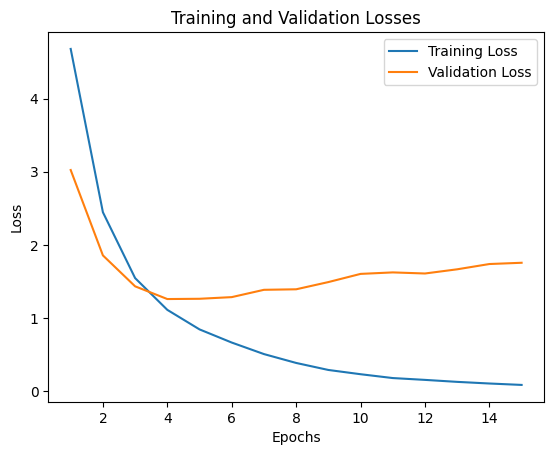

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# train_losses = train_losses
# val_losses = np.load('val_losses.npy')
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()


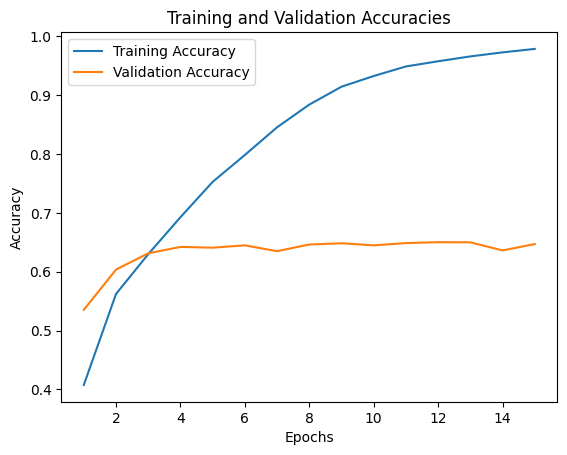

In [29]:
# train_accuracies = np.load('train_accuracies.npy')
# val_accuracies = np.load('val_accuracies.npy')
acc_list = [t.item() for t in tra_acc]
val_list = [t.item() for t in val_accuracies]
plt.plot(epochs, acc_list, label='Training Accuracy')
plt.plot(epochs, val_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')
plt.show()


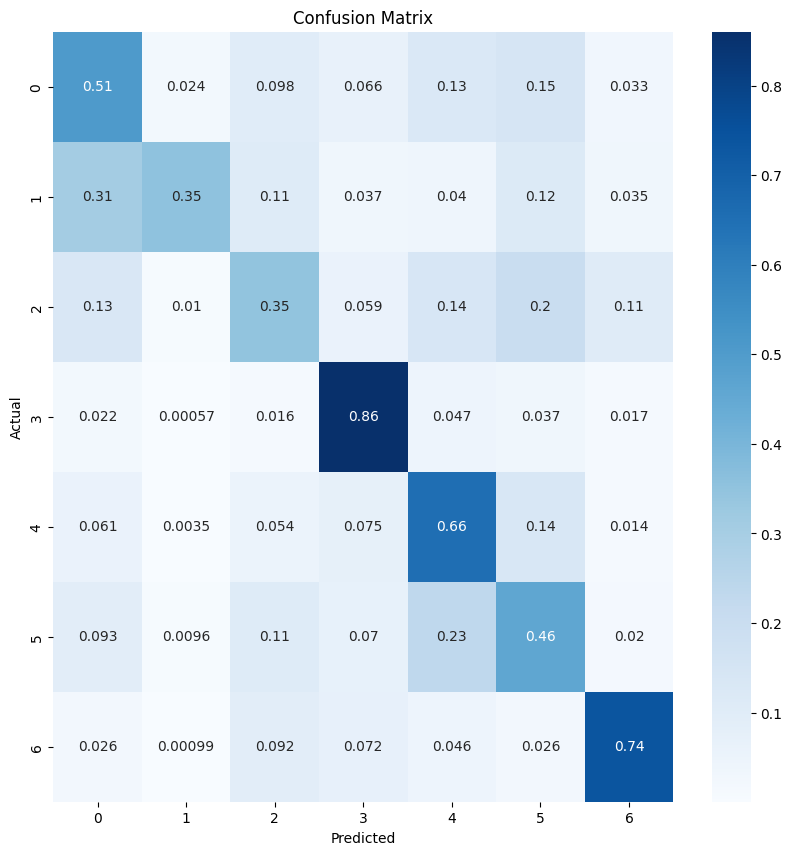

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

ground= np.array(ground_truth_labels)
pred = np.array(predictions)
classs = len(np.unique(ground_truth_labels))
cm = confusion_matrix(ground, pred, labels=range(classs))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
import torch
from torchvision.models import resnet18
from torchsummary import summary
import matplotlib.pyplot as plt

# Load the pretrained ResNet18 model
model = resnet18()

# Load your custom-trained model weights
model.load_state_dict(torch.load('best_model_res.pth'))

# Print the model architecture
summary(model, input_size=(3, 224, 224))

## Test a image

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models

def load_model(model_path):
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Identity()
    
    # Custom top layers
    output_layer = nn.Sequential(
        nn.Linear(num_ftrs, 7),
    )
    model.add_module('output', output_layer)
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

def predict_emotion(model, input_batch):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)
    model.to(device)
    with torch.no_grad():
        output = model(input_batch)
        _, predicted_emotion = torch.max(output, 1)
    return predicted_emotion.item()


In [ ]:
# Load the model and predict the emotion for an image
model_path = 'best_model_res.pth'
image_path = 'archive/train/angry/Training_3908.jpg'
model = load_model(model_path)
input_batch = preprocess_image(image_path)
predicted_emotion = predict_emotion(model, input_batch)

print("Predicted emotion:", predicted_emotion)

In [ ]:
# a dictionary to map the predicted emotion to the actual emotion
dict_emo = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
print("Predicted emotion:", dict_emo[predicted_emotion])

In [ ]:
# pip install torchviz
import torch
import torch.nn as nn
from torchvision import models
from torchviz import make_dot

def load_model(model_path):
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Identity()
    
    # Custom top layers
    output_layer = nn.Sequential(
        nn.Linear(num_ftrs, 7),
    )
    model.add_module('output', output_layer)
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load the saved model
model_path = 'best_model_res.pth'
model = load_model(model_path)

# Generate a random input tensor
input_tensor = torch.randn(1, 3, 224, 224)

# Get the output of the model
output = model(input_tensor)

# Visualize the model's architecture
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the visualization as an image
dot.format = 'png'
dot.render('loaded_model_architecture')

> plots

In [3]:

from torchvision.models import resnet18
from torchsummary import summary
import matplotlib.pyplot as plt

# Load the pretrained ResNet18 model
model = resnet18()

# Load your custom-trained model weights
model.load_state_dict(torch.load('best_model_res.pth'))

# Print the model architecture
summary(model, input_size=(3, 224, 224))


ModuleNotFoundError: No module named 'torchvision'